In [31]:
# Importing necessary files
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot, figure
from pandas import read_csv, DataFrame, concat, to_datetime
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [32]:
#Importing the dataset, removing unnecessary variables, filling all NA's with 0 for FEDFUNDS
df = read_csv('ucsbdata.csv')
raw_data = df[['Index','R', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'PER', 'EPS', 'FEDFUNDS']]
raw_data['FEDFUNDS'].fillna(0, inplace=True)

initial_start = '2008-08-30'
updated_dataset = raw_data.loc[raw_data.Index > initial_start]

# convert to datetime
updated_dataset['Index'] = to_datetime(df['Index'])
# set the index
updated_dataset.set_index('Index', inplace=True)
updated_dataset.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,R,OPEN,HIGH,LOW,CLOSE,PER,EPS,FEDFUNDS
Index,,,,,,,,
2008-09-02,-0.000925,1287.83,1303.04,1272.20,1277.58,25.664524,49.78,1.96
2008-09-03,-0.021012,1276.61,1280.60,1265.59,1274.98,25.612294,49.78,2.01
2008-09-04,0.003075,1271.80,1271.80,1232.83,1236.83,24.855908,49.76,1.99
2008-09-05,0.020380,1233.21,1244.94,1217.23,1242.31,24.966037,49.76,1.97
2008-09-08,-0.021026,1249.50,1274.42,1247.12,1267.79,25.483216,49.75,1.92


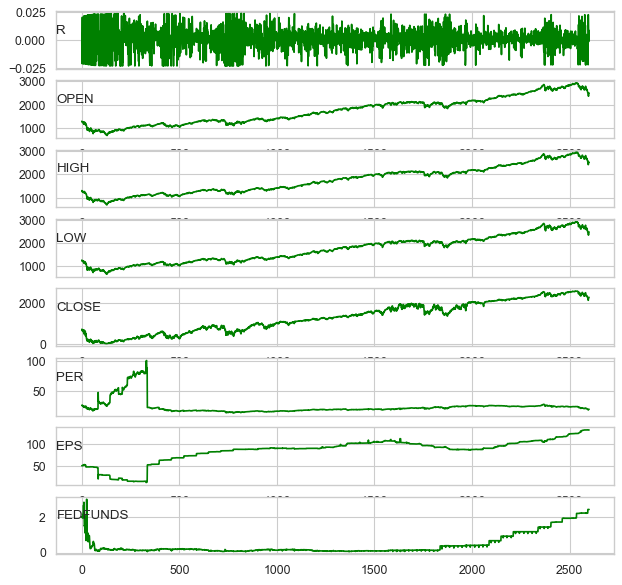

In [44]:
# Specify variables to run plot function
values = updated_dataset.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# Plot each column
pyplot.figure(num=None, figsize=(9, 9), dpi=80, facecolor='white', edgecolor='red')
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group], color = 'green')
    pyplot.title(updated_dataset.columns[group], y=0.5, loc='left')
    i += 1
pyplot.show()

In [46]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6]], axis=1, inplace=True)
len(updated_dataset.index)

2601

In [48]:
# split into train and test sets
values = reframed.values
n_train_days = 2080
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2080, 1, 14) (2080,) (520, 1, 14) (520,)


Train on 2080 samples, validate on 520 samples
Epoch 1/40
2080/2080 [==============================] - 2s 1ms/step - loss: 0.0087 - val_loss: 0.1238
Epoch 2/40
2080/2080 [==============================] - 0s 165us/step - loss: 0.0081 - val_loss: 0.1060
Epoch 3/40
2080/2080 [==============================] - 0s 166us/step - loss: 0.0083 - val_loss: 0.0932
Epoch 4/40
2080/2080 [==============================] - 0s 157us/step - loss: 0.0087 - val_loss: 0.0918
Epoch 5/40
2080/2080 [==============================] - 0s 147us/step - loss: 0.0089 - val_loss: 0.0983
Epoch 6/40
2080/2080 [==============================] - 0s 151us/step - loss: 0.0090 - val_loss: 0.1093
Epoch 7/40
2080/2080 [==============================] - 0s 149us/step - loss: 0.0089 - val_loss: 0.1198
Epoch 8/40
2080/2080 [==============================] - 0s 151us/step - loss: 0.0085 - val_loss: 0.1266
Epoch 9/40
2080/2080 [==============================] - 0s 161us/step - loss: 0.0079 - val_loss: 0.1295
Epoch 10/40
2080/20

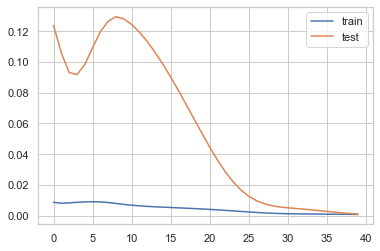

In [51]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs = 40, batch_size=35, 
                    validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [52]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (520,14) (8,) (520,14) 